<a href="https://www.kaggle.com/code/shedai/time-series-prediction-with-lstm?scriptVersionId=125077876" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-data-set/file_out2.csv
/kaggle/input/retail-data-set/file_out.csv


# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">Financial Prediction in Retail with LSTM</p>

In this project, I will be performing financial income prediction / forecasting project with using the time series approach on the customer's records from a retail industry firm's database. Financial prediction is the practice of time series approach with single or multiple time series input. I will also add more notebooks about financial prediction with different algorithms and approaches. One notebook already published for the seasonality test ( https://www.kaggle.com/code/shedai/sales-volume-seasonality ) with a single time series approach, more notebooks are coming. 

- Single Time Series Approach: Sales volume is one of the mostly predicted feature in the time series. In this approach, project aims to create a time series from daily, weekly or monthly sales data. Most of the time, there is only one time series with 2 features : time (dates) and sales volume.
- Multiple Parameter Time Series Approach: This type of approaches have multiple inputs, where all inputs are temporal (time dependent series) or we do feature engineering to create multiple inputs for the prediction model.

For this notebook, we will be using the Long-Short Term Memory (LSTM) technique from Keras / Tensorflow library. ( you can check the wikipedia link for further details : <a href = "https://en.wikipedia.org/wiki/Long_short-term_memory">https://en.wikipedia.org/wiki/Long_short-term_memory</a>

Note: You can also check a very similar notebook about CatBoost prediction, I have created a few days ago: <a href = "https://www.kaggle.com/code/shedai/financial-prediction-in-retail-with-catboost/edit"> https://www.kaggle.com/code/shedai/financial-prediction-in-retail-with-catboost/edit </a>

Another notebook for the same dataset and problem with Fast Fourier Transform (FFT) approach is available: <a href = "https://www.kaggle.com/code/shedai/sales-prediction-with-fft"> https://www.kaggle.com/code/shedai/sales-prediction-with-fft </a>

   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
      
* [3. Creating Time Series](#3)
    
* [4. Data Visualization and Analysis](#4)
    
* [5. Prediction / Forecasting with FFT](#5)
    
* [6. Evaluation](#6)
    
* [7. Conclusion](#7)
    
* [8. END](#8)

<a class="anchor"  id="1"></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;"> 1. Importing Libraries</p>  

In [2]:

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

<a id='#2'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">2. Loading Data</p>  
    
Now, we can load the data set and convert it to time series. The conversion requires the grouping dataset with the sum of sales for each day and type conversion to datetime format in pandas. 

In [3]:

df = pd.read_csv('/kaggle/input/retail-data-set/file_out2.csv')
df = df.groupby('Date').sum()
df['Date'] = df.index
df = df[['Date','TotalSales']]

df['Date'] = pd.to_datetime(df['Date'],format = '%Y-%m-%d')
df.head()

,Date,TotalSales
Date,,
2019-01-02,2019-01-02,26514.008475
2019-01-03,2019-01-03,21119.796609
2019-01-04,2019-01-04,16807.630509
2019-01-05,2019-01-05,15722.511525
2019-01-07,2019-01-07,38985.422907


<a id='#3'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">3. Creating Time Series</p>  

Now we will try to use the forecasting with LSTM. LSTM gets multiple parameters and one of the crucial point is, we need to normalize the data. Also the Keras library has a special shape requirement for the input layer of the neural network. We are starting to convert the data for the most suitable form for the LSTM input layer. 

Lets start with the target column first:

In [4]:

data = df[['TotalSales']]
# Convert the dataframe to a numpy array
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))
dataset

array([[ 26514.008475],
       [ 21119.796609],
       [ 16807.630509],
       ...,
       [ 80991.254236],
       [ 49362.644068],
       [152261.644066]])

Now, we can normalize the data with min-max normalizer (scaler) from sklearn framework.

In [5]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.05505216],
       [0.04372887],
       [0.03467697],
       ...,
       [0.16940834],
       [0.10301499],
       [0.31901593]])

Finally we split the train and test (validation) data sets and reshape the data set for LSTM input layer:

In [6]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

# we use 60 days ahead for forecasting range
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.05505216, 0.04372887, 0.03467697, 0.03239914, 0.08123159,
       0.03765613, 0.03713267, 0.05185081, 0.04967831, 0.09813776,
       0.06024841, 0.03197471, 0.04353289, 0.05296761, 0.03621742,
       0.05101549, 0.08155001, 0.05408682, 0.04599616, 0.04043715,
       0.04374727, 0.00841831, 0.03886221, 0.05157009, 0.04771211,
       0.11006656, 0.03282044, 0.12142995, 0.04584927, 0.01990992,
       0.02032816, 0.05171943, 0.05426571, 0.03428403, 0.03170346,
       0.03088479, 0.06095813, 0.07808612, 0.05529034, 0.05778999,
       0.04063897, 0.04087792, 0.05644246, 0.02927963, 0.02357336,
       0.03466835, 0.04789772, 0.02971627, 0.04060099, 0.11188443,
       0.00347491, 0.14997786, 0.04154853, 0.05826367, 0.0722317 ,
       0.07830238, 0.05173331, 0.07116849, 0.05099542, 0.06200969])]
[0.04112394768729019]

[array([0.05505216, 0.04372887, 0.03467697, 0.03239914, 0.08123159,
       0.03765613, 0.03713267, 0.05185081, 0.04967831, 0.09813776,
       0.06024841, 0.03197471, 0.04

<a id='#4'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">4. Data Visualization</p>

We can simply visualize the data set in time series with dataframe plot function.

<AxesSubplot:xlabel='Date'>

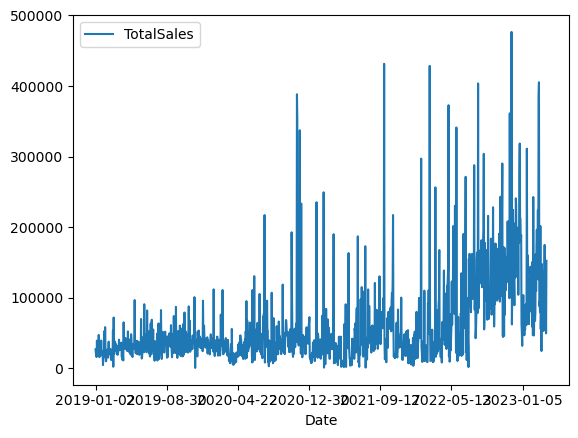

In [7]:
data.plot()

<a id='#5'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">5. Prediction and Forecasting with LSTM</p>  

Step by step, we will create neural network (deep learning) model with 1 input and model will have a shape like below:


input(60) x LSTM(128) x LSTM(64) x Dense(25) x Output(1)

the time series will run with 1 input and 1 output as the forecast. The LSTM and Dense layers will try to model the time series.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1145/1145 [==============================] - 39s 31ms/step - loss: 0.0116


We can now create a testing scenario and evaluate the success of the model:

In [9]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 31ms/step


75189.44182766223

Finally, lets visualize the train / test sets and the prediction on test set for the visual evaluation of succes.

<a id='#6'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">6. Evaluation</p>  
**What about future?** We can also use the whole data set for training and predict the future with 10% of data set date range again. 

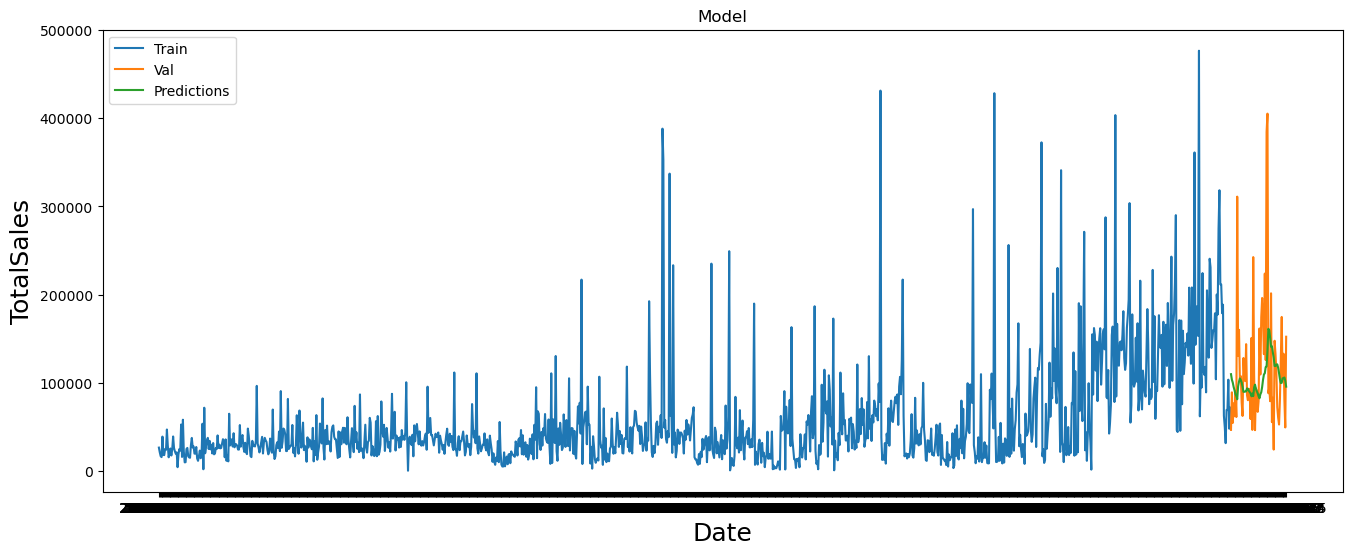

In [10]:
import matplotlib.pyplot as plt
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('TotalSales', fontsize=18)
plt.plot(train['TotalSales'])
plt.plot(valid[['TotalSales', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

<a id='#7'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">7. Conclusion</p> 
We have started with a sales data in retail industry and created a financial times series and extracted total sales volume per date. Date parameter is in daily frequency so we have created a time series and converted the datatime format for the LSTM library. Finally we have the predictions for the test and future forecasts. Hope you enjoyed the notebook and dont forget to upvote if you liked it.

<a id='#8'></a>
# <p style="background-color:#BDBDBD;font-family:newtimeroman;color:#D3463F;font-size:150%;text-align:center;border-radius:10px 10px;">8. END</p>
Hello, my name is Sadi Evren SEKER and this is a notebook just for fun. You can reach me by <a href = "https://www.sadievrenseker.com">https://www.sadievrenseker.com</a> (my homepage) or my udemy courses ( <a href="https://www.udemy.com/user/sadievrenseker/">https://www.udemy.com/user/sadievrenseker/</a> ) or my youtube channel ( <a href ="https://www.youtube.com/@dataconcepts">https://www.youtube.com/@dataconcepts </a> ) or my linkedin profile ( <a href = "https://www.linkedin.com/in/sadiseker/"> https://www.linkedin.com/in/sadiseker/</a>) , Also the notebook of Fares Sayah had a high impact in this notebook (<a href = "https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm">https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm</a>, bests.